In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("dataset_telemetry.csv")

In [4]:
df.head(10)

,Unnamed: 0,userid,sessionid,timestamp,action,value,category,age,gender,city
0,0,user_10000,1,2021-12-30T12:28:45,category,0.000000,Товары для детей,42,Ж,Красноярск
1,1,user_10000,1,2021-12-30T12:29:10,search,0.000000,Товары для детей,42,Ж,Красноярск
2,2,user_10000,1,2021-12-30T12:29:25,product,0.000000,Товары для детей,42,Ж,Красноярск
3,3,user_10000,1,2021-12-30T12:29:26,search,0.000000,Товары для детей,42,Ж,Красноярск
4,4,user_10000,1,2021-12-30T12:29:34,search,0.000000,Товары для детей,42,Ж,Красноярск
5,5,user_10000,1,2021-12-30T12:29:46,product,0.000000,Товары для детей,42,Ж,Красноярск
6,6,user_10000,1,2021-12-30T12:30:14,search,0.000000,Товары для детей,42,Ж,Красноярск
7,7,user_10000,1,2021-12-30T12:30:45,category,0.000000,Товары для детей,42,Ж,Красноярск
8,8,user_10000,1,2021-12-30T12:30:48,cart,5735.262266,Авто/мото товары,42,Ж,Красноярск
9,9,user_10000,1,2021-12-30T12:30:52,checkout,6130.000000,NaN,42,Ж,Красноярск


In [5]:
df["action"].unique()

array(['category', 'search', 'product', 'cart', 'checkout', 'mainpage',
       'confirmation'], dtype=object)

In [6]:
# Преобразуем timestamp в datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

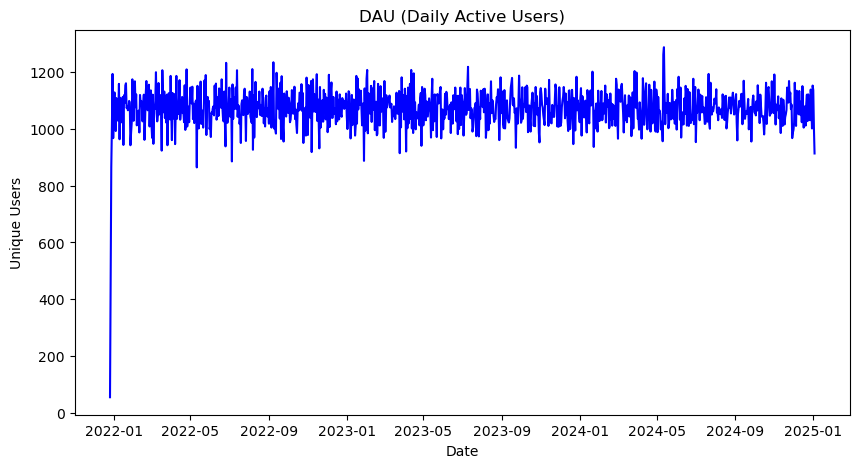

In [7]:
# --- 1. DAU ---
dau = df.groupby('date')['userid'].nunique()
plt.figure(figsize=(10, 5))
dau.plot(title="DAU (Daily Active Users)", color='blue')
plt.xlabel("Date")
plt.ylabel("Unique Users")
plt.show()


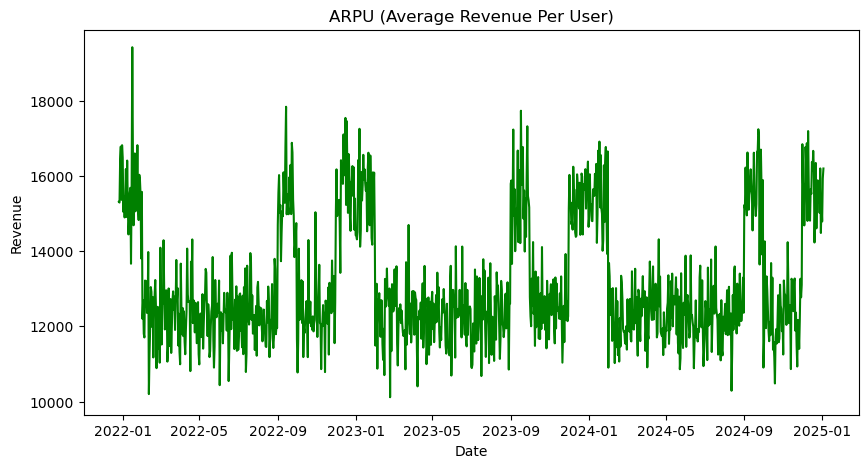

In [8]:
# --- 2. ARPU ---
revenue_per_day = df.groupby('date')['value'].sum()
arpu = revenue_per_day / dau
plt.figure(figsize=(10, 5))
arpu.plot(title="ARPU (Average Revenue Per User)", color='green')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

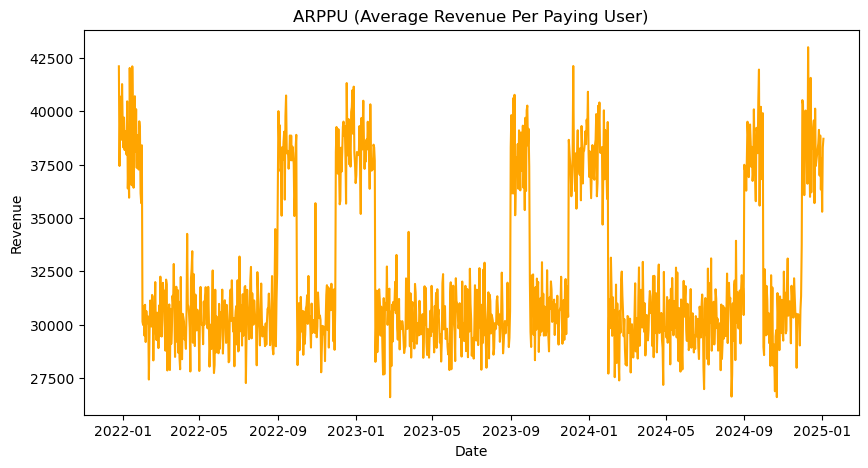

In [9]:
# --- 3. ARPPU ---
paying_users_per_day = df[df['value'] > 0].groupby('date')['userid'].nunique()
arppu = revenue_per_day / paying_users_per_day
plt.figure(figsize=(10, 5))
arppu.plot(title="ARPPU (Average Revenue Per Paying User)", color='orange')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

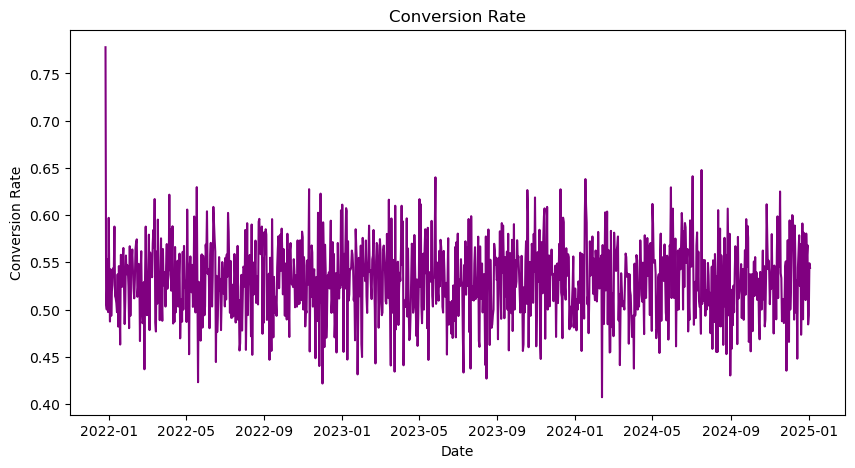

In [10]:
# --- 4. Conversion Rate из корзины в покупку---
actions = df.groupby(['date', 'action'])['userid'].nunique().unstack(fill_value=0)
conversion_rate = actions['confirmation'] / actions['checkout']
plt.figure(figsize=(10, 5))
conversion_rate.plot(title="Conversion Rate", color='purple')
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.show()

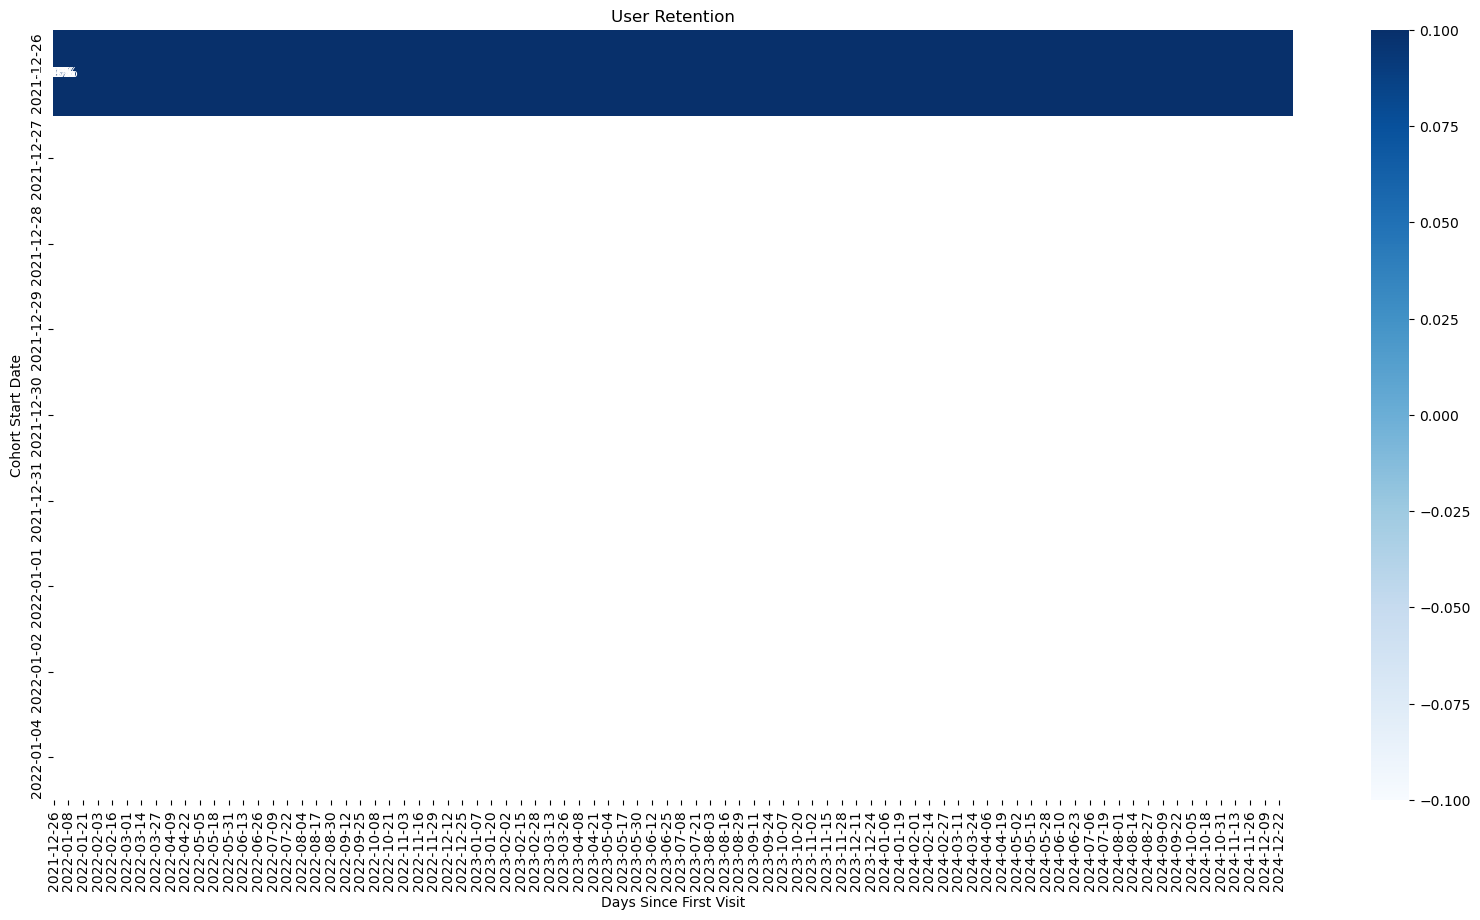

In [11]:
# здесь проблемы, пока думаю как сделать, чтобы работало 
# --- 5. Retention ---
def get_retention_table(df):
    df['cohort'] = df.groupby('userid')['date'].transform('min')
    cohort_pivot = (df.groupby(['cohort', 'date'])['userid']
                      .nunique()
                      .unstack(fill_value=0))
    cohort_size = cohort_pivot.iloc[:, 0]
    retention = cohort_pivot.divide(cohort_size, axis=0)
    return retention

retention = get_retention_table(df)
plt.figure(figsize=(20, 10))
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues")
plt.title("User Retention")
plt.xlabel("Days Since First Visit")
plt.ylabel("Cohort Start Date")
plt.show()

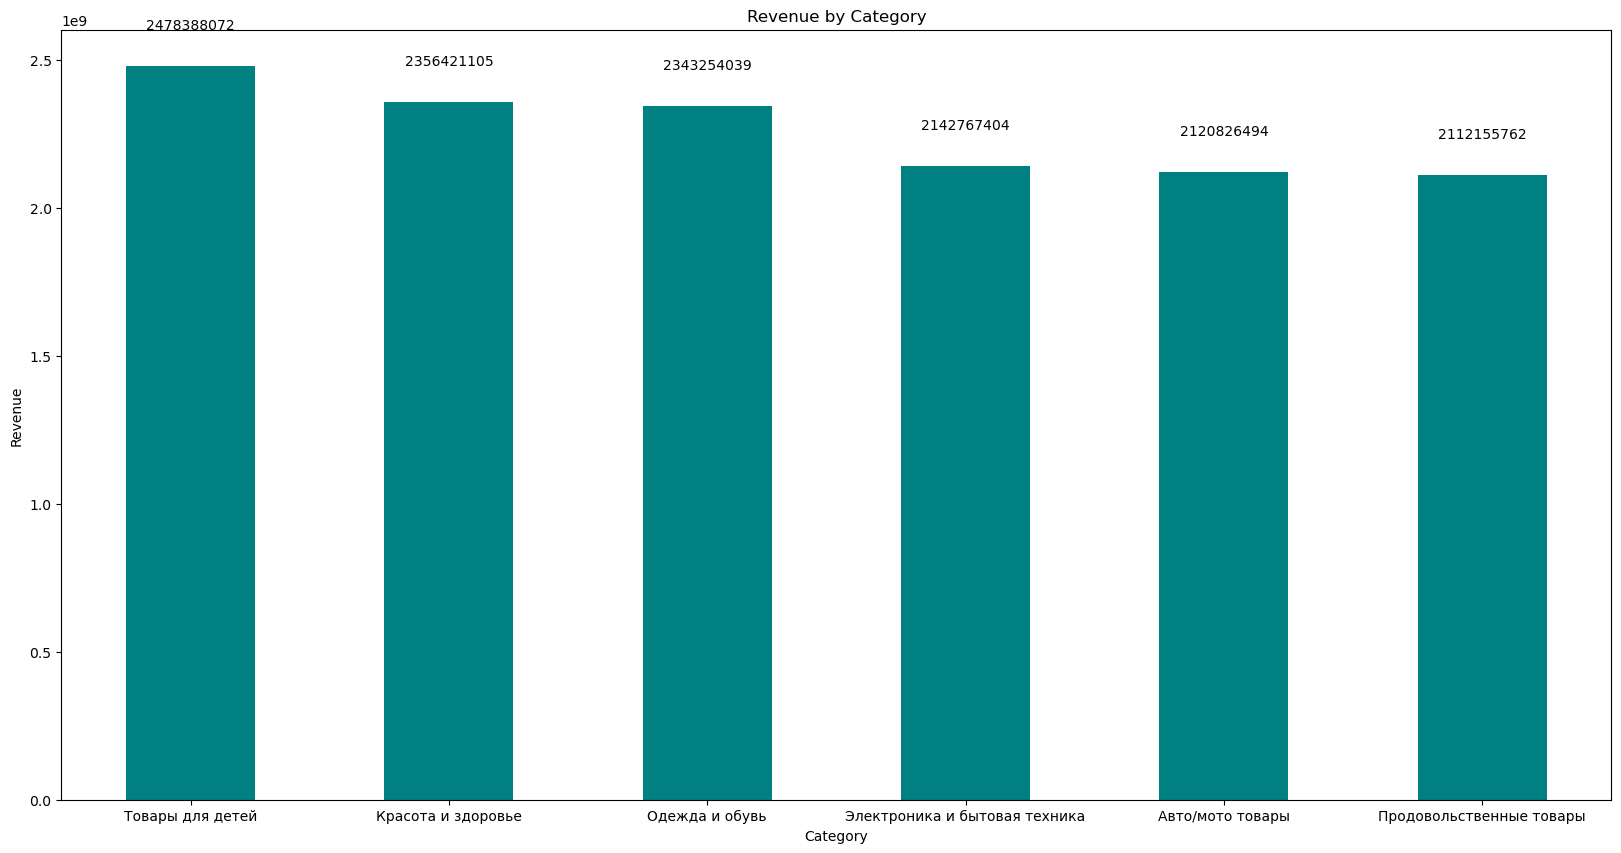

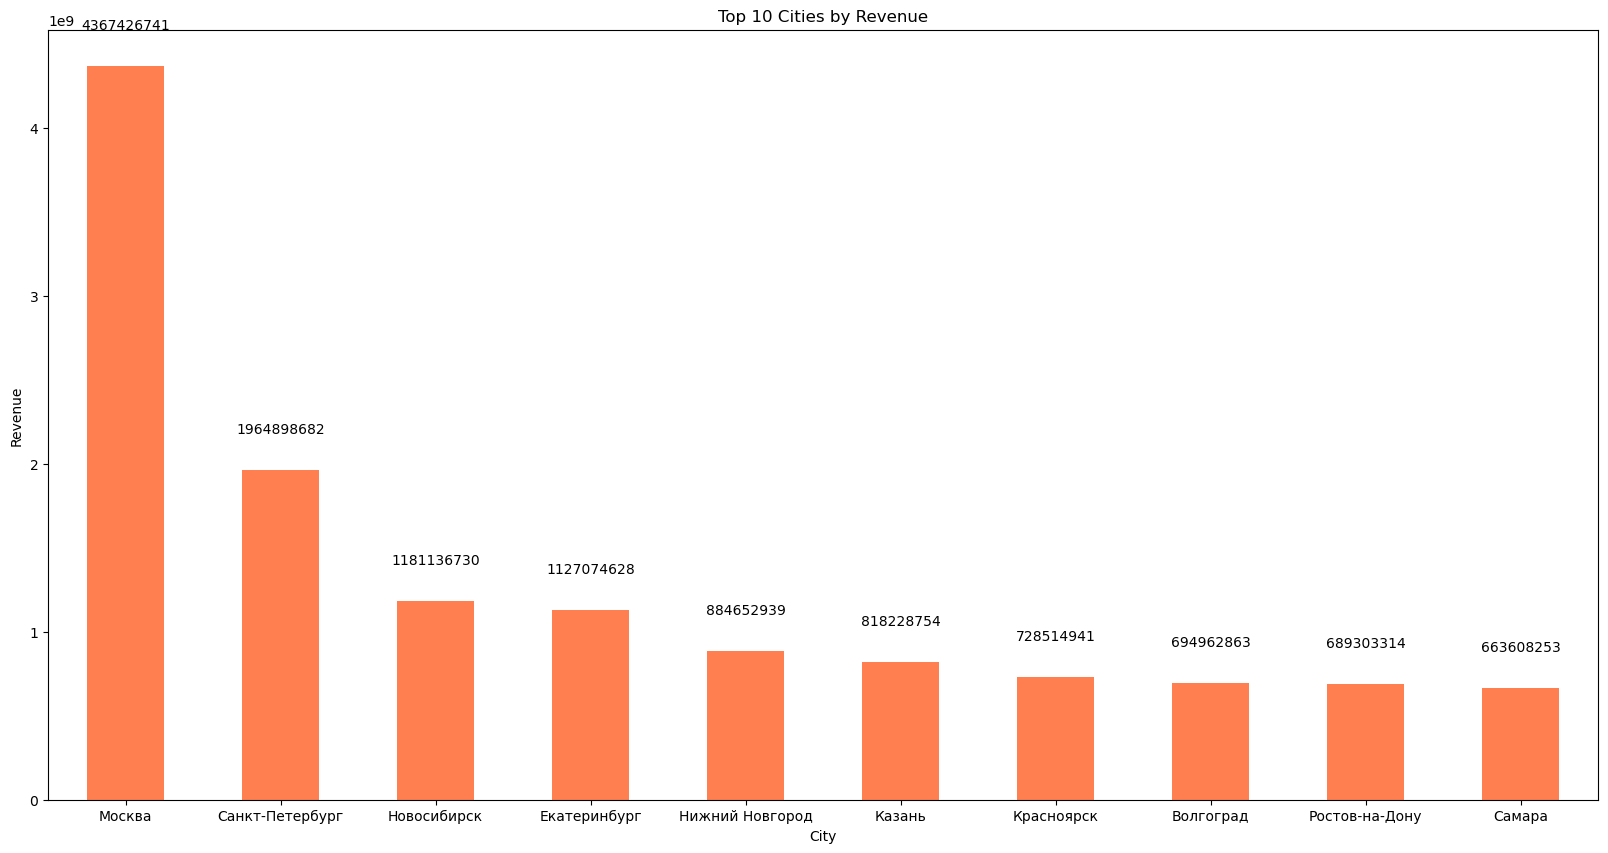

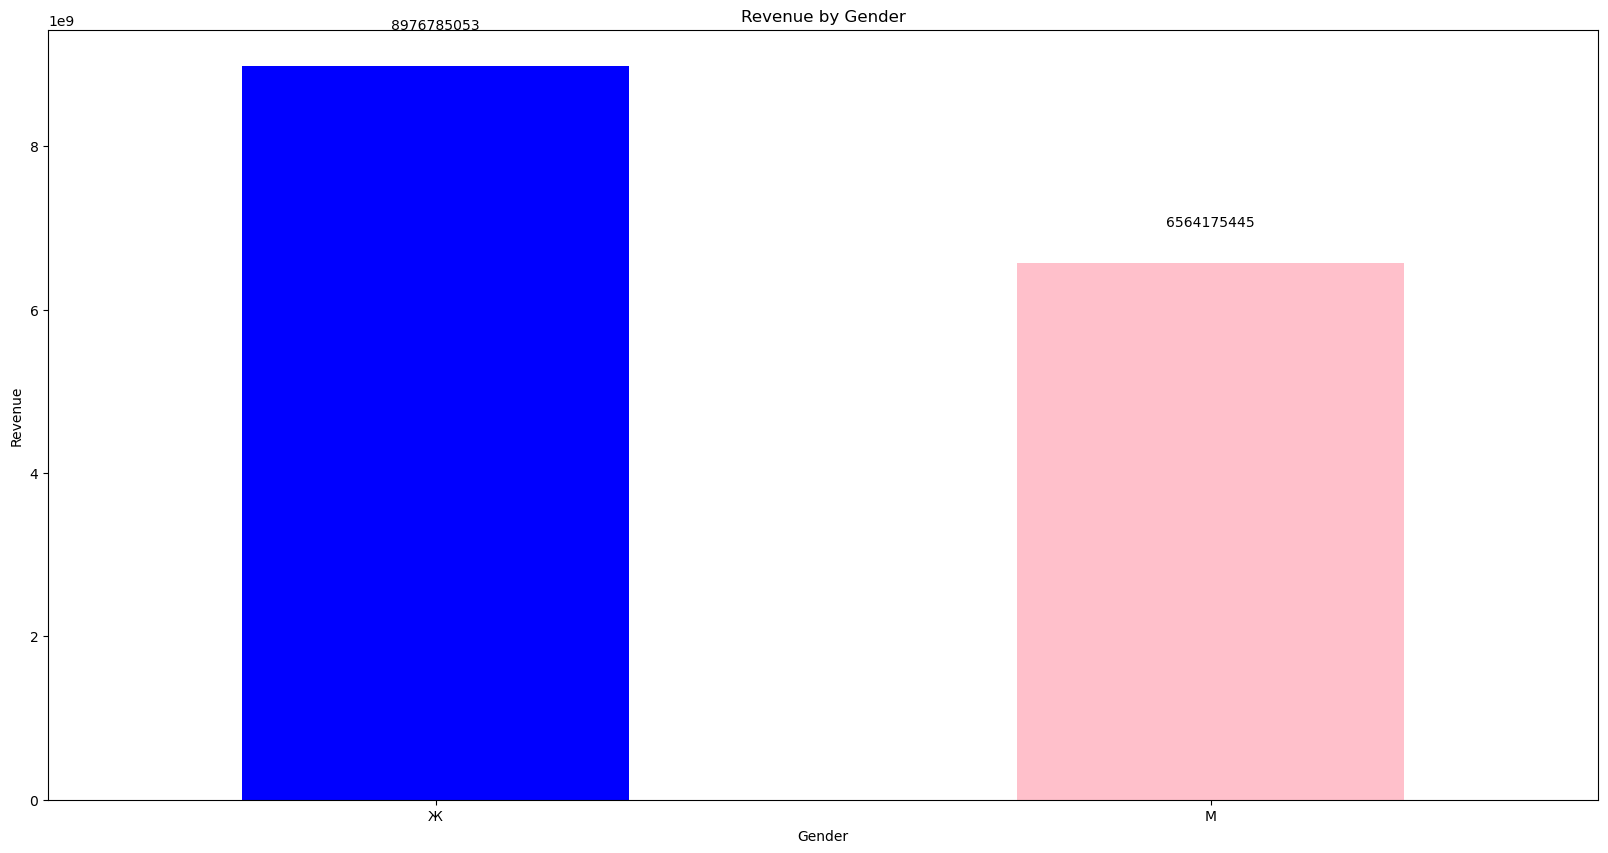

In [12]:
# --- 6. Анализ по городам, категориям, полу ---
category_revenue = df.groupby('category')['value'].sum().sort_values(ascending=False)
plt.figure(figsize=(20, 10))
category_revenue.plot(kind='bar', title="Revenue by Category", color='teal', rot = 0, figsize=(20,10))
for i, v in enumerate(category_revenue):
    plt.text(i, v + 0.05 * max(category_revenue), f"{int(v)}", ha='center')
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.show()

city_revenue = df.groupby('city')['value'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(20, 10))
city_revenue.plot(kind='bar', title="Top 10 Cities by Revenue", color='coral', rot = 0, figsize=(20,10))
for i, v in enumerate(city_revenue):
    plt.text(i, v + 0.05 * max(city_revenue), f"{int(v)}", ha='center')
plt.xlabel("City")
plt.ylabel("Revenue")
plt.show()

gender_revenue = df.groupby('gender')['value'].sum()
plt.figure(figsize=(20, 10))
gender_revenue.plot(kind='bar', title="Revenue by Gender", color=['blue', 'pink'], rot = 0, figsize=(20,10))
for i, v in enumerate(gender_revenue):
    plt.text(i, v + 0.05 * max(gender_revenue), f"{int(v)}", ha='center')
plt.xlabel("Gender")
plt.ylabel("Revenue")
plt.show()

In [14]:
# попытка визуализации какие пары товаров покупают чаще чем товары поотдельности 
from itertools import combinations
from collections import Counter

# Фильтрация данных для покупок
purchases = df[df['action'] == 'confirmation']

# Группировка по sessionid и получение списков категорий товаров
grouped = purchases.groupby('sessionid')['category'].apply(list)

# Генерация всех возможных пар товаров
pairs = grouped.apply(lambda x: list(combinations(x, 2)))

pair_counts = Counter([pair for sublist in pairs for pair in sublist])

pair_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Count']).sort_values(by='Count', ascending=False)

# Фильтрация пар с частотой больше, чем у отдельных товаров
single_counts = purchases['category'].value_counts()
frequent_pairs = pair_df[pair_df['Pair'].apply(lambda pair: pair_counts[pair] > min(single_counts[pair[0]], single_counts[pair[1]]) if pair[0] in single_counts and pair[1] in single_counts else False)]

# Построение графика
#plt.figure(figsize=(10, 5))
#frequent_pairs.head(10).plot(kind='bar', x='Pair', y='Count', legend=False, color='skyblue')
#plt.title("Top 10 Frequently Bought Together Pairs")
#plt.xlabel("Product Pair")
#plt.ylabel("Count")
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
#plt.show()